In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as patches

%matplotlib inline

gr      = 1.618
flux_corr = 1.028
outdir = './Output/Dirt/'

In [2]:
def inTPC(row):
    if 0 < row['_nu_vtx_x'] < 256.35:
        if 0 < row['_nu_vtx_z'] < 1036.8:
            if -116.5 < row['_nu_vtx_y'] < 116.5:
                return True
    return False

In [3]:
file = uproot.open("input/mc_bnb_dirt_10kevents_new.root")["wouterana"]

In [4]:
file.keys()

[b'MCParticles;5',
 b'MCParticles;4',
 b'PFParticles;2',
 b'PFParticles;1',
 b'pot;1',
 b'Event;1',
 b'OpBeamFlashes;1',
 b'SimpleBeamFlashes;1',
 b'OpCosmicFlashes;1',
 b'SimpleCosmicFlashes;1',
 b'Clusters;1']

8939


9909

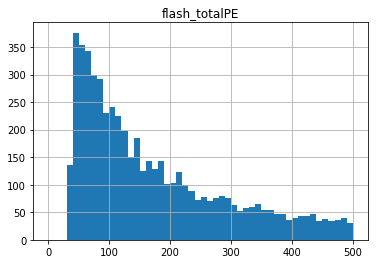

In [5]:
flash_tree = file[b'SimpleBeamFlashes']  
flash_df = flash_tree.pandas.df(flash_tree.keys())
flash_df.head()
flash_df.hist('flash_totalPE', range=(0,500),bins=50)

print(flash_df['event'].nunique())
len(flash_df)

In [6]:
pot_tree = file[b'pot']  
pot_tree = pot_tree.arrays(b'pot')
print('Total POT of events: ', sum(pot_tree[b'pot']))

Total POT of events:  2.8004295223669686e+19


In [7]:
event_tree = file[b'Event']  
print(event_tree.keys())
event_tree.array(b'num_nu')

nu_x = event_tree.array(b'nu_vtx_x')
nu_y = event_tree.array(b'nu_vtx_y')
nu_z = event_tree.array(b'nu_vtx_z')
nu_t = event_tree.array(b'nu_time')
nu_E = event_tree.array(b'nu_E')
nu_pdg = event_tree.array(b'nu_pdg_code')

print(event_tree.numentries)

[b'event', b'run', b'subrun', b'pot', b'n_events', b'dataset_prescale_factor', b'num_simplebeamflashes', b'num_opbeamflashes', b'num_simplecosmicflashes', b'num_opcosmicflashes', b'num_pfp', b'num_mcp', b'num_mcp_saved', b'num_nu', b'nu_vtx_x', b'nu_vtx_y', b'nu_vtx_z', b'nu_E', b'nu_time', b'nu_pdg_code', b'nu_ccnc']
10000


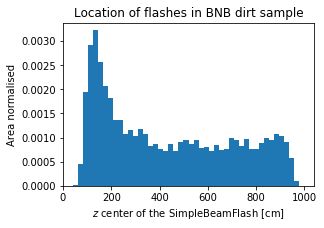

In [8]:
plt.figure(figsize=(4.5,3))
plt.hist(flash_df['flash_z'],range=(0,1040),bins=50,density=1)
plt.xlabel(r'$z$ center of the SimpleBeamFlash [cm]')
plt.ylabel(r'Area normalised')
plt.title(r'Location of flashes in BNB dirt sample')
plt.xlim(0,1040)
plt.savefig( outdir+"dirt_flash_z.pdf", bbox_inches="tight")

In [9]:
mcp_tree = file[b'MCParticles']  
mcp_cols = [b'event', b'run', b'subrun', 
            b'mc_energy', b'mc_pdg_code', b'mc_status_code',
            b'fMc_part_inside', b'fMc_kBeamNeutrino', b'mc_time', 
            b'mc_startx', b'mc_starty', b'mc_startz']

mcp_df = mcp_tree.pandas.df(mcp_cols)
mcp_df = mcp_df.query('fMc_kBeamNeutrino==True & ((mc_pdg_code==11 | mc_pdg_code==13) & mc_status_code==1)')
mcp_df.head()

,event,run,subrun,mc_energy,mc_pdg_code,mc_status_code,fMc_part_inside,fMc_kBeamNeutrino,mc_time,mc_startx,mc_starty,mc_startz
135,190538,2,20,0.292752,13,1,True,True,3508.608398,-610.663513,196.988693,670.043701
293,190538,2,20,0.292752,13,1,True,True,3508.608398,-610.663513,196.988693,670.043701
295,191002,2,20,0.955912,13,1,True,True,4237.616211,405.303284,103.277634,-273.073761
526,191002,2,20,0.955912,13,1,True,True,4237.616211,405.303284,103.277634,-273.073761
1663,193901,2,20,0.903093,13,1,True,True,4124.919922,-636.747925,459.876343,236.226074


(array([147., 150., 155., 188.,  38.,   9.,   7.,   4.,   8.]),
 array([4.7      , 4.733333 , 4.766667 , 4.8      , 4.8333335, 4.866667 ,
        4.9      , 4.9333334, 4.9666667, 5.       ], dtype=float32),
 <a list of 9 Patch objects>)

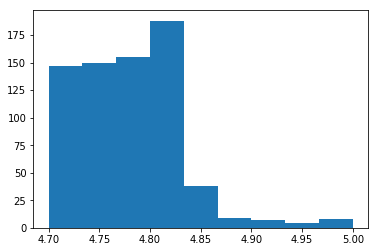

In [10]:
#np.array(tree[b'mc_start_inside'])
plt.hist(flash_df['flash_time'],range=(4.7,5.0), bins=9)

In [11]:
nu_caused_flash_x = []
nu_caused_flash_y = []
nu_caused_flash_z = []

query_str = 'flash_time>3.16 & flash_time<4.84 & flash_totalPE>50'

for index, row in flash_df.query(query_str).iterrows():
    event = row['event']
    subrun = row['subrun']
    run = row['run']
    query_str = 'event==@event & run==@run & subrun==@subrun'
    mcp_event = mcp_df.query(query_str)
    if len(mcp_event>0):
        mcp = mcp_event.iloc[0]
        dt = row['flash_time'] - mcp['mc_time']/1000
        if 0 < dt < 0.2:
            #print('match!',dt)
            nu_caused_flash_x.append(mcp['mc_startx'])
            nu_caused_flash_y.append(mcp['mc_starty'])
            nu_caused_flash_z.append(mcp['mc_startz'])

            

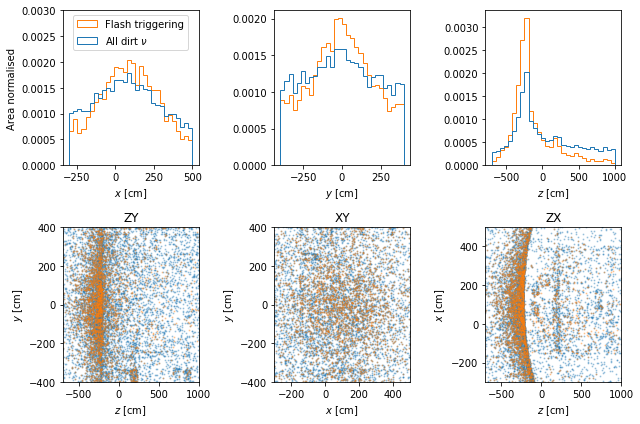

In [12]:
nu_x = event_tree.array(b'nu_vtx_x').flatten()
nu_y = event_tree.array(b'nu_vtx_y').flatten()
nu_z = event_tree.array(b'nu_vtx_z').flatten()

fig, ax = plt.subplots(2,3, figsize=(9,6))
labs = [r'All dirt $\nu$', r'Flash triggering']
ax[0][0].hist([nu_x.flatten(),nu_caused_flash_x], histtype='step',bins=30, range=(-300,500), density=1, label=labs)
ax[0][0].legend(loc='upper center')
ax[0][0].set_ylim(0,0.003)
ax[0][0].set_xlabel(r'$x$ [cm]')
ax[0][0].set_ylabel('Area normalised')

ax[0][1].hist([nu_y.flatten(),nu_caused_flash_y], histtype='step',bins=30, range=(-400,400), density=1, label=labs)
ax[0][1].set_xlabel(r'$y$ [cm]')

ax[0][2].hist([nu_z.flatten(),nu_caused_flash_z], histtype='step',bins=30, range=(-700,1000), density=1, label=labs)
ax[0][2].set_xlabel(r'$z$ [cm]')

ax[1][0].scatter(nu_z, nu_y, s=1,alpha=0.3)
ax[1][0].scatter(nu_caused_flash_z, nu_caused_flash_y, s=1,alpha=0.3)
ax[1][0].set_xlabel(r'$z$ [cm]')
ax[1][0].set_ylabel(r'$y$ [cm]')
ax[1][0].set_xlim(-700,1000)
ax[1][0].set_ylim(-400,400)
ax[1][0].set_title(r'ZY')

ax[1][1].scatter(nu_x, nu_y, s=1,alpha=0.3)
ax[1][1].scatter(nu_caused_flash_x, nu_caused_flash_y, s=1,alpha=0.3)
ax[1][1].set_xlabel(r'$x$ [cm]')
ax[1][1].set_ylabel(r'$y$ [cm]')
ax[1][1].set_xlim(-300,500)
ax[1][1].set_ylim(-400,400)
ax[1][1].set_title(r'XY')

ax[1][2].scatter(nu_z, nu_x, s=1,alpha=0.3)
ax[1][2].scatter(nu_caused_flash_z, nu_caused_flash_x, s=1,alpha=0.3)
ax[1][2].set_xlabel(r'$z$ [cm]')
ax[1][2].set_ylabel(r'$x$ [cm]')
ax[1][2].set_xlim(-700,1000)
ax[1][2].set_ylim(-300,500)
ax[1][2].set_title(r'ZX')

fig.tight_layout()
plt.savefig( outdir+"dirt_space.png", bbox_inches="tight",dpi=200)

#Plot all variables in all trees
for treename in file:
    tree = file[treename]
    tree = tree.arrays(tree.keys())
    print('Name tree:',treename.decode("utf-8").split(';')[0])
    print('With fields:')
    print(tree.keys())
    for field in tree:
        print(field.decode("utf-8") )
        data = tree[field]
        if type(data[0]) is np.bool_ :
            data = np.int_(data)
        plt.hist(data[data>-9000])
        plt.title(field.decode("utf-8"))
        plt.show()

## Flash plot, now with dirt sample!

In [13]:
#The statistical uncertainity per bin of the binned data.
#If there are weights then the uncertainity will be the root of the
#sum of the weights squared.
def hist_bin_uncertainty(data, weights, bin_edges):
    # Bound the data and weights to be within the bin edges
    in_range_index = [idx for idx in range(len(data)) if data[idx] > min(bin_edges) and data[idx] < max(bin_edges)]
    in_range_data = np.asarray([data[idx] for idx in in_range_index])
    in_range_weights = np.asarray([weights[idx] for idx in in_range_index])

    # Bin the weights with the same binning as the data
    bin_index = np.digitize(in_range_data, bin_edges)
    # N.B.: range(1, bin_edges.size) is used instead of set(bin_index) as if
    # there is a gap in the data such that a bin is skipped no index would appear
    # for it in the set
    binned_weights = np.asarray(
        [in_range_weights[np.where(bin_index == idx)[0]] for idx in range(1, len(bin_edges))])
    bin_uncertainties = np.asarray(
        [np.sqrt(np.sum(np.square(w))) for w in binned_weights])
    return bin_uncertainties

In [14]:
df_nu = pd.read_pickle("/home/wouter/Documents/Jupyter/LEE_analyzer/Notebooks/Tools/input/df_nu_flash.pckl")
df_ext = pd.read_pickle("/home/wouter/Documents/Jupyter/LEE_analyzer/Notebooks/Tools/input/df_bnbext_a_flash.pckl")
df_bnb = pd.concat(
         [pd.read_pickle("/home/wouter/Documents/Jupyter/LEE_analyzer/Notebooks/Tools/input/df_bnb_a_flash.pckl"), 
          pd.read_pickle("/home/wouter/Documents/Jupyter/LEE_analyzer/Notebooks/Tools/input/df_bnb_b_flash.pckl")])

dirt_pot = 2.80043e+19
nu_pot = 1.998317e+20
bnb_pot = 4.413e+19
ext_trig = 14255249
ext_scale = 9779224/ext_trig

In [15]:
mc_start = 3.16
bnb_start = 3.19     # mc_start + 2*0.015625 #3.20
ext_start = 3.58     # mc_start + 26*0.015625 #3.58
duration = 1.68

In [16]:
# Parameters to geth the data mc ration in the right spot
ratio_x = 0.70
ratio_y = 8./9
ratio_text = r"$\frac{Beam \ ON}{Beam \ OFF + MC} = $"

In [17]:
nu_flash = np.hstack(df_nu["flash_time"])
bnb_flash = np.hstack(df_bnb["flash_time"])
ext_flash = np.hstack(df_ext["flash_time"])
dirt_flash = flash_df['flash_time']


dirt_PE = flash_df.query('flash_time>3.16 & flash_time<4.84')['flash_totalPE']
dirt_flash_z = flash_df.query('flash_time>3.16 & flash_time<4.84 & flash_totalPE>50')['flash_z']
print(len(dirt_flash))

9909


In [18]:
df_ext["bnbweight"] = ext_scale
df_bnb["bnbweight"] = 1

nu_scale = bnb_pot/nu_pot
ext_weights = np.array([ext_scale]*len(ext_flash))
nu_weights = np.array([nu_scale]*len(nu_flash))*0.985 # 0.985 is the average weight 
dirt_weights_all = np.array([bnb_pot/dirt_pot]*len(dirt_flash))
dirt_weights = np.array([bnb_pot/dirt_pot]*len(dirt_PE))

50


/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


0.9570884920622068


/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in double_scalars


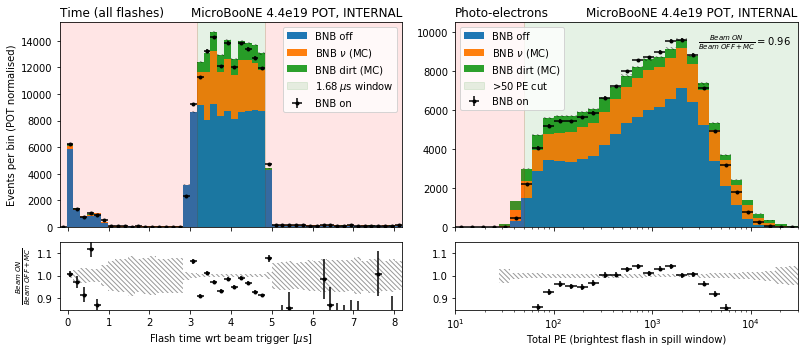

In [61]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(7*gr,5),sharex='col', gridspec_kw = {'height_ratios':[3, 1]})

y_r_min=0.85
y_r_max=1.15

ext_weights = np.array([ext_scale]*len(ext_flash))
nu_weights = np.array([nu_scale]*len(nu_flash))*flux_corr*0.985 # 0.985 is the average weight 

#Left plot
x_min = -0.2
x_max = 8.2
N= round((x_max-x_min)/0.168)
print(N)
bhalf = (x_max-x_min)/(2*N)

#if we are using overlaid instead of MC, we use # -(ext_start-mc_start)
bins,edges = np.histogram(bnb_flash-(bnb_start-mc_start),bins=N,range=(x_min,x_max))
ax[0][0].errorbar(edges[:-1]+bhalf, bins, xerr=bhalf, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB on")
lower,_,_ = ax[0][0].hist(ext_flash-(ext_start-mc_start),alpha=1.0,bins=N, range = (x_min, x_max), weights = ext_weights, label = "BNB off" )
mc_bins,_,_ = ax[0][0].hist(nu_flash,alpha=1.0,bins=N, range = (x_min, x_max), weights = nu_weights, label=r"BNB $\nu$ (MC)",  bottom = lower )
mc_bins+=lower 
dirt_bins,_,_ = ax[0][0].hist(dirt_flash,alpha=1.0,bins=N, range = (x_min, x_max), weights = dirt_weights_all, label=r"BNB dirt (MC)",  bottom = mc_bins )
mc_bins+=dirt_bins

ax[0][0].axvspan(x_min,mc_start, alpha=0.1, color="red")
ax[0][0].axvspan(mc_start,mc_start+duration, alpha=0.1, color="green",label=str(duration)+"$\: \mu$s window" )
ax[0][0].axvspan(mc_start+duration,x_max, alpha=0.1, color="red")

ax[0][0].set_title(r"Time (all flashes)", loc='left')
ax[0][0].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')

ax[1][0].set_xlabel(r"Flash time wrt beam trigger [$\mu$s]")
ax[0][0].set_ylabel(r"Events per bin (POT normalised)")
ax[0][0].legend(loc="upper right")
ax[0][0].set_xlim(x_min,x_max)

# Ratio plot left
mc_ext_err = np.sqrt(  (np.sqrt(mc_bins/nu_scale)*nu_scale)**2 + (np.sqrt(lower/ext_scale)*ext_scale)**2)
for this_err,entry,bin_start in zip(mc_ext_err,mc_bins,edges[:-1]):
    ax[0][0].add_patch(patches.Rectangle( (bin_start, entry-this_err), bhalf*2, this_err*2, hatch="\\\\\\\\\\",Fill=False, linewidth=0,alpha=0.4))
    sc_err = this_err/entry
    ax[1][0].add_patch(patches.Rectangle( (bin_start, 1-sc_err), bhalf*2, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
ax[1][0].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][0].errorbar(edges[:-1]+bhalf, bins/mc_bins, xerr=bhalf, yerr=np.sqrt(bins)/mc_bins ,alpha=1.0, color= "k",fmt=".",label="Data error")
ax[1][0].set_ylim(y_r_min,y_r_max)


# Right plot
x_min = 10
x_max = 30000
N=32
bhalf = (x_max-x_min)/(2*N)
edges=np.logspace(np.log10(x_min),np.log10(x_max), N)
x_err= [(edges[i+1]-edges[i])/2 for i in range(N-1)]
y_max = 10500

edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N-1)]
                         
bins,_ = np.histogram(df_bnb.query("flash_PE_max>1")["flash_PE_max"],bins=edges)
ax[0][1].errorbar(edges_mid, bins, xerr=x_err, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB on")
lower,_,_ = ax[0][1].hist(df_ext["flash_PE_max"],alpha=1.0,bins=edges, weights = df_ext["bnbweight"], label = "BNB off" )
mc_bins,_,_ = ax[0][1].hist(df_nu["flash_PE_max"],alpha=1.0,bins=edges, weights = df_nu["bnbweight"]*nu_scale, label=r"BNB $\nu$ (MC)",  bottom = lower )
mc_bins+=lower
dirt_bins,_,_ = ax[0][1].hist(dirt_PE,alpha=1.0,bins=edges, weights = dirt_weights, label=r"BNB dirt (MC)",  bottom = mc_bins )
mc_bins+=dirt_bins
ax[0][1].set_title(r"Photo-electrons", loc='left')
ax[0][1].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')


ax[1][1].set_xlabel(r"Total PE (brightest flash in spill window)")
ax[0][1].set_xlim(x_min,x_max)
ax[0][1].set_ylim(0,y_max)
ax[0][1].axvspan(x_min,50, alpha=0.1, color="red")
ax[0][1].axvspan(50,x_max, alpha=0.1, color="green",label=">$50 \:$PE cut" )
ax[0][1].legend(loc="upper left")
ax[0][1].set_xscale("log", nonposx='clip')

ax[1][1].errorbar(edges_mid, bins/mc_bins, xerr=x_err, yerr=np.sqrt(bins)/mc_bins ,alpha=1.0, color= "k",fmt=".",label="Data error")
ax[1][1].set_ylim(y_r_min,y_r_max)

ratio = df_bnb.query("flash_PE_max>1")["bnbweight"].sum() / ( df_ext.query("flash_PE_max>1")["bnbweight"].sum() + df_nu.query("flash_PE_max>1")["bnbweight"].sum()*nu_scale + len(dirt_PE)*bnb_pot/dirt_pot )
print(ratio)
ratio = sum(bins)/sum(mc_bins)
ax[0][1].text(edges[round(N*ratio_x)],ratio_y*y_max,ratio_text+'{0:.2f}'.format(ratio))

# Ratio plots
mc_err_weighted = hist_bin_uncertainty(df_nu.query("flash_PE_max>1")["flash_PE_max"].tolist(), 
                                       df_nu.query("flash_PE_max>1")["bnbweight"].tolist(), edges)

mc_ext_err = np.sqrt(  (np.array(mc_err_weighted)*nu_scale)**2 + (np.sqrt(lower/ext_scale)*ext_scale)**2)

for this_err,entry,bin_start,bin_end in zip(mc_ext_err,mc_bins,edges[:-1],edges[1:]):
    ax[0][1].add_patch(patches.Rectangle( (bin_start, entry-this_err), bin_end-bin_start, this_err*2, hatch="\\\\\\\\\\",Fill=False, linewidth=0,alpha=0.4))
    sc_err = this_err/entry
    ax[1][1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), bin_end-bin_start, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

fig.tight_layout(h_pad=0.5)
plt.savefig( outdir+"time_pe_ratio.pdf")

In [32]:
file = uproot.open("/home/wouter/Templates/July/bnb_nu_cosmic_0s0t_dev/10272555_98.root")['wouterNueCC/pandoratree']
file.keys()

[b'category',
 b'n_tracks',
 b'n_showers',
 b'ccnc',
 b'qsqr',
 b'theta',
 b'vx',
 b'vy',
 b'vz',
 b'fiducial',
 b'true_vx',
 b'true_vy',
 b'true_vz',
 b'true_nu_fiducial',
 b'true_shower_x_sce',
 b'true_shower_y_sce',
 b'true_shower_z_sce',
 b'true_shower_pdg',
 b'true_shower_depE',
 b'true_vx_sce',
 b'true_vy_sce',
 b'true_vz_sce',
 b'lepton_E',
 b'lepton_theta',
 b'nu_E',
 b'passed',
 b'numu_passed',
 b'numu_cuts',
 b'n_true_nu',
 b'distance',
 b'n_matched',
 b'nu_matched_tracks',
 b'nu_matched_showers',
 b'nu_daughters_pdg',
 b'nu_daughters_E',
 b'nu_daughters_vx',
 b'nu_daughters_vy',
 b'nu_daughters_vz',
 b'nu_daughters_endx',
 b'nu_daughters_endy',
 b'nu_daughters_endz',
 b'nu_daughters_px',
 b'nu_daughters_py',
 b'nu_daughters_pz',
 b'nu_track_ids',
 b'nu_shower_ids',
 b'nu_shower_daughters',
 b'nu_track_daughters',
 b'event',
 b'run',
 b'subrun',
 b'bnbweight',
 b'chosen_candidate',
 b'candidate_pdg',
 b'n_primaries',
 b'primary_indexes',
 b'number_tracks',
 b'number_showers',

In [67]:
bnb_nu_flash_z=[]
bnb_nu_weight = []
for arrays in uproot.iterate("/home/wouter/Templates/July/bnb_nu_cosmic_0s0t_dev/*.root",'wouterNueCC/pandoratree', ['flash_time', 'flash_PE', 'flash_z','bnbweight'],entrysteps=1000000):
    bnb_nu_flash_z.extend(arrays[b'flash_z'])
    bnb_nu_weight.extend(arrays[b'bnbweight'])
bnb_nu_flash_z = np.array(bnb_nu_flash_z)
bnb_nu_weight = np.array(bnb_nu_weight)

In [22]:
bnb_on_flash_z=[]
for arrays in uproot.iterate("/home/wouter/Templates/July/data_bnb_a_0s0t/*.root",'wouterNueCC/pandoratree', ['flash_time', 'flash_PE', 'flash_z'],entrysteps=1000000):
    bnb_on_flash_z.extend(arrays[b'flash_z'])
for arrays in uproot.iterate("/home/wouter/Templates/July/data_bnb_b_0s0t/*.root",'wouterNueCC/pandoratree', ['flash_time', 'flash_PE', 'flash_z'],entrysteps=1000000):
    bnb_on_flash_z.extend(arrays[b'flash_z'])
bnb_on_flash_z= np.array(bnb_on_flash_z)

In [23]:
bnb_off_flash_z=[]
for arrays in uproot.iterate("/home/wouter/Templates/July/data_bnbext_a_0s0t/*.root",'wouterNueCC/pandoratree', ['flash_time', 'flash_PE', 'flash_z'],entrysteps=1000000):
    bnb_off_flash_z.extend(arrays[b'flash_z'])
bnb_off_flash_z= np.array(bnb_off_flash_z)

126435
185080
433388


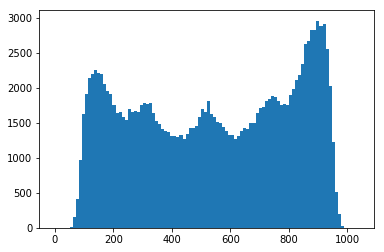

In [68]:
plt.hist(bnb_nu_flash_z, range=(0,1040), bins=100)
print(len(df_ext.query("flash_PE_max>1")))
print(len(df_ext))
print(len(bnb_off_flash_z))
bnb_nu_flash_z_weights  = bnb_nu_weight*nu_scale
bnb_off_flash_z_weights = np.ones(len(bnb_off_flash_z))*ext_scale*185080/433388
dirt_weights = np.array([bnb_pot/dirt_pot]*len(dirt_flash_z))

50


/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars


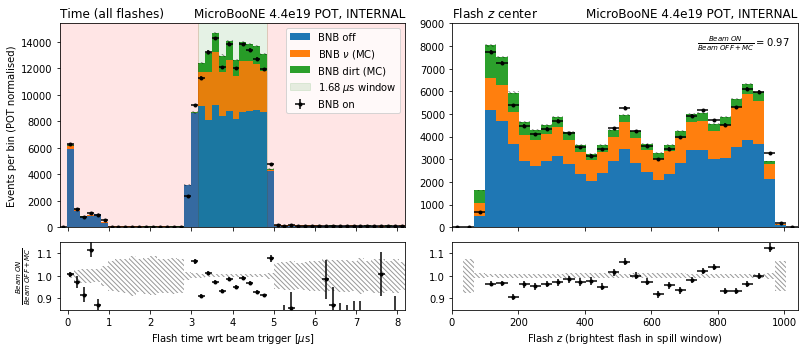

In [74]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(7*gr,5),sharex='col', gridspec_kw = {'height_ratios':[3, 1]})

y_r_min=0.85
y_r_max=1.15

ext_weights = np.array([ext_scale]*len(ext_flash))
nu_weights = np.array([nu_scale]*len(nu_flash))*flux_corr*0.985 # 0.985 is the average weight 

#Left plot
x_min = -0.2
x_max = 8.2
N= round((x_max-x_min)/0.168)
print(N)
bhalf = (x_max-x_min)/(2*N)

#if we are using overlaid instead of MC, we use # -(ext_start-mc_start)
bins,edges = np.histogram(bnb_flash-(bnb_start-mc_start),bins=N,range=(x_min,x_max))
ax[0][0].errorbar(edges[:-1]+bhalf, bins, xerr=bhalf, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB on")
lower,_,_ = ax[0][0].hist(ext_flash-(ext_start-mc_start),alpha=1.0,bins=N, range = (x_min, x_max), weights = ext_weights, label = "BNB off" )
mc_bins,_,_ = ax[0][0].hist(nu_flash,alpha=1.0,bins=N, range = (x_min, x_max), weights = nu_weights, label=r"BNB $\nu$ (MC)",  bottom = lower )
mc_bins+=lower 
dirt_bins,_,_ = ax[0][0].hist(dirt_flash,alpha=1.0,bins=N, range = (x_min, x_max), weights = dirt_weights_all, label=r"BNB dirt (MC)",  bottom = mc_bins )
mc_bins+=dirt_bins

ax[0][0].axvspan(x_min,mc_start, alpha=0.1, color="red")
ax[0][0].axvspan(mc_start,mc_start+duration, alpha=0.1, color="green",label=str(duration)+"$\: \mu$s window" )
ax[0][0].axvspan(mc_start+duration,x_max, alpha=0.1, color="red")

ax[0][0].set_title(r"Time (all flashes)", loc='left')
ax[0][0].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')

ax[1][0].set_xlabel(r"Flash time wrt beam trigger [$\mu$s]")
ax[0][0].set_ylabel(r"Events per bin (POT normalised)")
ax[0][0].legend(loc="upper right")
ax[0][0].set_xlim(x_min,x_max)

# Ratio plot left
mc_ext_err = np.sqrt(  (np.sqrt(mc_bins/nu_scale)*nu_scale)**2 + (np.sqrt(lower/ext_scale)*ext_scale)**2)
for this_err,entry,bin_start in zip(mc_ext_err,mc_bins,edges[:-1]):
    ax[0][0].add_patch(patches.Rectangle( (bin_start, entry-this_err), bhalf*2, this_err*2, hatch="\\\\\\\\\\",Fill=False, linewidth=0,alpha=0.4))
    sc_err = this_err/entry
    ax[1][0].add_patch(patches.Rectangle( (bin_start, 1-sc_err), bhalf*2, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
ax[1][0].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][0].errorbar(edges[:-1]+bhalf, bins/mc_bins, xerr=bhalf, yerr=np.sqrt(bins)/mc_bins ,alpha=1.0, color= "k",fmt=".",label="Data error")
ax[1][0].set_ylim(y_r_min,y_r_max)


# Right plot
x_min = 0
x_max = 1040
N=32
bhalf = (x_max-x_min)/(2*N)
edges=np.linspace(x_min, x_max, N)
x_err= [(edges[i+1]-edges[i])/2 for i in range(N-1)]
y_max = 9000

edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N-1)]
                         
bins,_ = np.histogram(bnb_on_flash_z,bins=edges)
ax[0][1].errorbar(edges_mid, bins, xerr=x_err, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB on")
lower,_,_ = ax[0][1].hist(bnb_off_flash_z,alpha=1.0,bins=edges, weights = bnb_off_flash_z_weights, label = "BNB off" )
mc_bins,_,_ = ax[0][1].hist(bnb_nu_flash_z,alpha=1.0,bins=edges, weights = bnb_nu_flash_z_weights, label=r"BNB $\nu$ (MC)",  bottom = lower )
mc_bins+=lower
dirt_bins,_,_ = ax[0][1].hist(dirt_flash_z,alpha=1.0,bins=edges, weights = dirt_weights, label=r"BNB dirt (MC)",  bottom = mc_bins )
mc_bins+=dirt_bins
ax[0][1].set_title(r"Flash $z$ center", loc='left')
ax[0][1].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')


ax[1][1].set_xlabel(r"Flash $z$ (brightest flash in spill window)")
ax[0][1].set_xlim(x_min,x_max)
ax[0][1].set_ylim(0,y_max)

ax[1][1].errorbar(edges_mid, bins/mc_bins, xerr=x_err, yerr=np.sqrt(bins)/mc_bins ,alpha=1.0, color= "k",fmt=".",label="Data error")
ax[1][1].set_ylim(y_r_min,y_r_max)

ratio = sum(bins)/sum(mc_bins)
ax[0][1].text(edges[round(N*ratio_x)],ratio_y*y_max,ratio_text+'{0:.2f}'.format(ratio))

# Ratio plots
mc_err_weighted = hist_bin_uncertainty(bnb_nu_flash_z.tolist(), 
                                       bnb_nu_flash_z_weights.tolist(), edges)

mc_ext_err = np.sqrt(  (np.array(mc_err_weighted)*nu_scale)**2 + (np.sqrt(lower/ext_scale)*ext_scale)**2)

for this_err,entry,bin_start,bin_end in zip(mc_ext_err,mc_bins,edges[:-1],edges[1:]):
    ax[0][1].add_patch(patches.Rectangle( (bin_start, entry-this_err), bin_end-bin_start, this_err*2, hatch="\\\\\\\\\\",Fill=False, linewidth=0,alpha=0.4))
    sc_err = this_err/entry
    ax[1][1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), bin_end-bin_start, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

fig.tight_layout(h_pad=0.5)
plt.savefig( outdir+"flash_dirt_z.pdf")